#**Diabetic Retinopathy Detection**

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Load the dataset
data_dir = '/content/drive/MyDrive/colored_images'

In [3]:
def load_data(data_dir):
    categories = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.resize(img_array, (224, 224))  # Resize images to 224x224 for CNN
                data.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(e)
    return np.array(data), np.array(labels)

data, labels = load_data(data_dir)

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [5]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
# Feature extraction using pre-trained VGG16 for SVM and KNN
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
X_train_features = vgg.predict(X_train)
X_test_features = vgg.predict(X_test)
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

23/23 [==============================] - 13s 583ms/step


In [7]:
# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_features, y_train)
y_pred_svm = svm_model.predict(X_test_features)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.52      0.55        94
           1       0.67      0.68      0.68       201
           2       0.93      0.97      0.95       342
           3       0.32      0.40      0.36        47
           4       0.44      0.24      0.32        49

    accuracy                           0.75       733
   macro avg       0.59      0.56      0.57       733
weighted avg       0.74      0.75      0.74       733



In [8]:
# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_features, y_train)
y_pred_knn = knn_model.predict(X_test_features)
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))


KNN Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.56      0.51        94
           1       0.60      0.67      0.63       201
           2       0.89      0.97      0.93       342
           3       0.22      0.09      0.12        47
           4       0.20      0.02      0.04        49

    accuracy                           0.71       733
   macro avg       0.48      0.46      0.45       733
weighted avg       0.67      0.71      0.68       733



In [30]:
# Deep Learning model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(set(labels)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
92/92 [==============================] - 67s 721ms/step - loss: 0.9850 - accuracy: 0.6535 - val_loss: 0.9012 - val_accuracy: 0.6862
Epoch 2/10
92/92 [==============================] - 65s 712ms/step - loss: 0.8158 - accuracy: 0.7057 - val_loss: 0.8408 - val_accuracy: 0.6944
Epoch 3/10
92/92 [==============================] - 66s 721ms/step - loss: 0.7900 - accuracy: 0.7183 - val_loss: 0.8168 - val_accuracy: 0.7067
Epoch 4/10
92/92 [==============================] - 66s 719ms/step - loss: 0.7584 - accuracy: 0.7173 - val_loss: 0.7839 - val_accuracy: 0.7121
Epoch 5/10
92/92 [==============================] - 67s 729ms/step - loss: 0.7344 - accuracy: 0.7306 - val_loss: 0.7864 - val_accuracy: 0.7053
Epoch 6/10
92/92 [==============================] - 65s 710ms/step - loss: 0.7301 - accuracy: 0.7347 - val_loss: 0.8415 - val_accuracy: 0.6903
Epoch 7/10
92/92 [==============================] - 65s 712ms/step - loss: 0.7030 - accuracy: 0.7422 - val_loss: 0.7774 - val_accuracy: 0.7080

In [31]:
# Evaluate the deep learning model
scores = model.evaluate(X_test, y_test)
print(f"Deep Learning Model Accuracy: {scores[1]*100}%")

23/23 [==============================] - 14s 606ms/step - loss: 0.7478 - accuracy: 0.7108
Deep Learning Model Accuracy: 71.07776403427124%


SVM Accuracy: 0.7489768076398363
KNN Accuracy: 0.7148703956343793
Deep Learning Model Accuracy: 70.66848278045654%


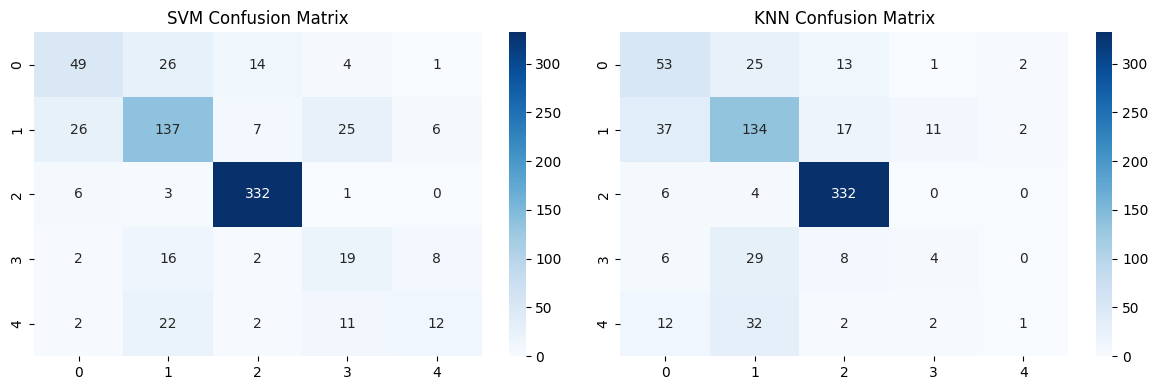

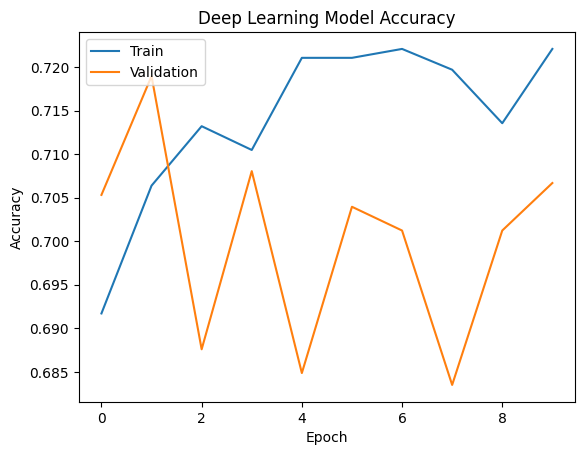

In [34]:
# compare all model
from sklearn.metrics import confusion_matrix
# Compare models
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(f"Deep Learning Model Accuracy: {scores[1]*100}%")

# You can also visualize the performance metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')

plt.tight_layout()
plt.show()

# Plot training history for deep learning model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Deep Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [11]:
# Grad-CAM visualization
def get_gradcam_heatmap(model, image, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('block5_conv3').output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = (tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads)

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap


In [12]:
def get_gradcam_heatmap(model, image, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('block5_conv3').output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = (tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads)

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output.numpy(), weights.numpy())  # Convert to numpy arrays
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

1/1 [==============================] - 0s 195ms/step


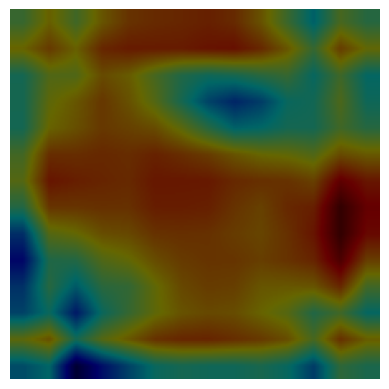

In [13]:
def display_gradcam(image, heatmap):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap * 0.4 + image * 0.6)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.show()

sample_image = X_test[0]
pred_class = np.argmax(model.predict(np.expand_dims(sample_image, axis=0)))
heatmap = get_gradcam_heatmap(model, sample_image, pred_class)
display_gradcam(sample_image, heatmap)